In [74]:
# 1) Importar as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


In [75]:
df = pd.read_excel("C:\\Users\\Paulo\\Desktop\\MBA DATASCIENCE\\Regression\\Book2.xlsx")

In [76]:
df.head()

,Serial No.,TICKET MEDIO,GASTO MENSAL,SCORE SERASA
0,1,960,8410,19
1,2,3872,3193,10
2,3,3192,17509,78
3,4,566,16358,45
4,5,4526,16432,63


In [77]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Serial No.    10000 non-null  int64
 1   TICKET MEDIO  10000 non-null  int64
 2   GASTO MENSAL  10000 non-null  int64
 3   SCORE SERASA  10000 non-null  int64
dtypes: int64(4)
memory usage: 312.6 KB
None


In [78]:
# 3) Remover coluna de ID, pois não é útil para clustering
if 'Serial No.' in df.columns:
    df = df.drop(columns=['Serial No.'])

# Selecionar as colunas que vamos usar para o agrupamento
features = ['TICKET MEDIO', 'GASTO MENSAL', 'SCORE SERASA']

# Conferir estatísticas rápidas das features
df[features].describe()


,TICKET MEDIO,GASTO MENSAL,SCORE SERASA
count,10000.000000,10000.000000,10000.000000
mean,2569.483600,10394.434600,49.348400
std,1410.003893,5644.882754,29.043422
min,101.000000,503.000000,0.000000
25%,1339.750000,5503.500000,24.000000
50%,2600.000000,10452.500000,49.000000
75%,3788.500000,15409.250000,75.000000
max,4999.000000,19991.000000,99.000000


In [79]:
# 4) Escalar os dados (KMeans é sensível a escala)
scaler = StandardScaler()
X = scaler.fit_transform(df[features])


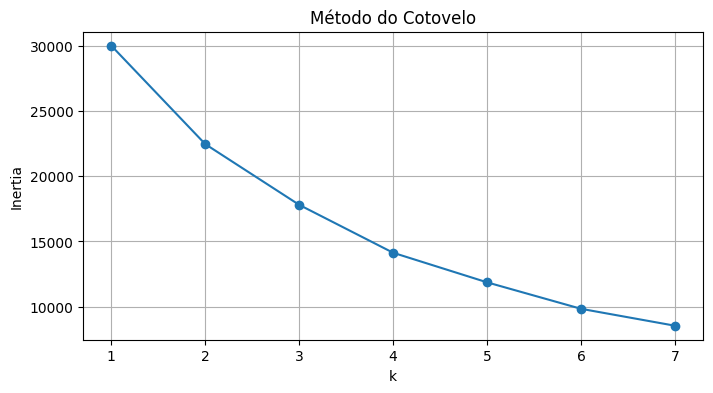

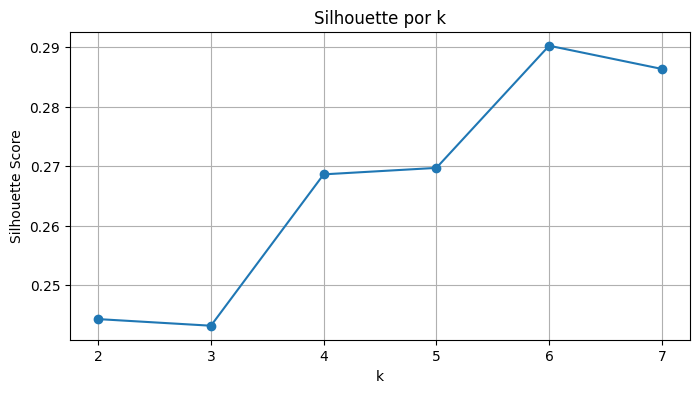

In [80]:
# 5) Calcular métricas para diferentes k
inertias = []
sil_scores = []
ks = range(1, 8)

for k in ks:
    km = KMeans(n_clusters=k, init='k-means++', n_init=50, random_state=42)
    km.fit(X)
    inertias.append(km.inertia_)
    if k >= 2:
        sil_scores.append(silhouette_score(X, km.labels_))
    else:
        sil_scores.append(np.nan)

# Plot do método do cotovelo (Elbow)
plt.figure(figsize=(8,4))
plt.plot(ks, inertias, '-o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Método do Cotovelo')
plt.xticks(ks)
plt.grid(True)
plt.show()

# Plot do silhouette score
plt.figure(figsize=(8,4))
plt.plot(ks[1:], sil_scores[1:], '-o')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette por k')
plt.xticks(ks[1:])
plt.grid(True)
plt.show()


In [94]:
# 6) Defina o k escolhido com base nos gráficos
chosen_k = 4  # ajuste conforme o seu caso

# Treinar o modelo
kmeans = KMeans(n_clusters=chosen_k, init='k-means++', n_init=50, random_state=42)
kmeans.fit(X)

# Labels dos clusters
labels = kmeans.labels_


In [96]:
# 7) Criar coluna com nomes g1, g2, g3...
df['cluster'] = ['g' + str(i+1) for i in labels]

# Visualizar primeiros registros
df.head()


,TICKET MEDIO,GASTO MENSAL,SCORE SERASA,cluster
0,960,8410,19,g3
1,3872,3193,10,g3
2,3192,17509,78,g2
3,566,16358,45,g1
4,4526,16432,63,g2


In [97]:
# 8) Tamanho dos clusters
print("Tamanho de cada cluster:")
print(df['cluster'].value_counts())

# 9) Centros dos clusters na escala original
centers_scaled = kmeans.cluster_centers_
centers_original = scaler.inverse_transform(centers_scaled)
centers_df = pd.DataFrame(centers_original, columns=features)
centers_df.index = ['g' + str(i+1) for i in range(chosen_k)]

print("\nCentros dos clusters (na escala original):")
centers_df


Tamanho de cada cluster:
cluster
g1    2623
g3    2522
g2    2451
g4    2404
Name: count, dtype: int64

Centros dos clusters (na escala original):


,TICKET MEDIO,GASTO MENSAL,SCORE SERASA
g1,2430.099006,15600.712920,25.538609
g2,3854.225846,11099.417856,74.896861
g3,2793.617729,4919.681440,26.954491
g4,1174.629368,9764.548253,72.728369


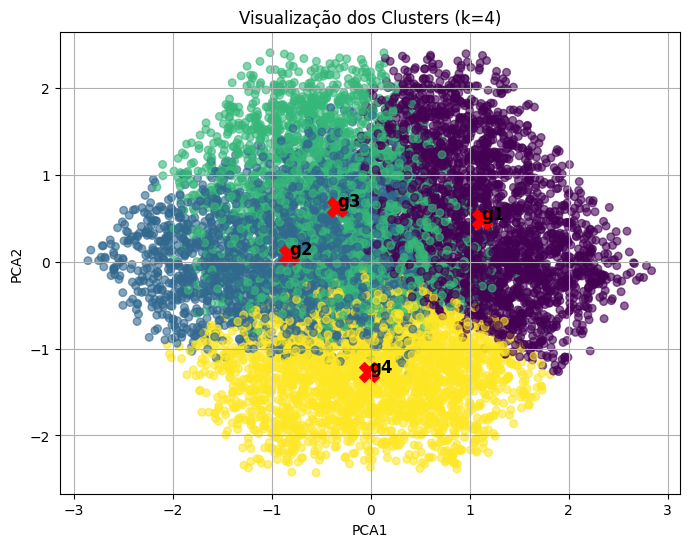

In [98]:
# 10) PCA para reduzir para 2 dimensões e plotar
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)
pca_centers = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='viridis', s=30, alpha=0.6)
plt.scatter(pca_centers[:,0], pca_centers[:,1], marker='X', s=200, color='red')

# Adicionar rótulo dos centros
for i, (x,y) in enumerate(pca_centers):
    plt.text(x, y, 'g'+str(i+1), fontsize=12, fontweight='bold')

plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title(f'Visualização dos Clusters (k={chosen_k})')
plt.grid(True)
plt.show()


In [85]:
# 11) Salvar CSV com a nova coluna 'cluster'
df.to_csv('dataset_com_clusters.csv', index=False)
print("Dataset salvo como 'dataset_com_clusters.csv'")


Dataset salvo como 'dataset_com_clusters.csv'
